In [1]:
from datasets import Dataset, load_dataset, features, ClassLabel, load_from_disk

import pandas as pd
import numpy as np
import scipy.stats as stats
import researchpy as rp
from itertools import chain

import networkx as nx
import community as community_louvain
from networkx.algorithms.community import k_clique_communities
from networkx.algorithms import bipartite

import seaborn as sns
import matplotlib.pyplot as plt
import pydot
from networkx.drawing.nx_pydot import graphviz_layout

import statsmodels.formula.api as smf
from stargazer.stargazer import Stargazer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA

import torch
import os

from llm_mri import LLM_MRI

/home/figenio/Projetos/data_science/experimentacao/graph_experimenting/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Visualizando resultados

In [2]:
# exp = "_iam"
# exp = "_dpoc"
exp = "_both"

if "both" in exp:
    df_read_iam = pd.read_csv('data/comparacao_f_pca_pt_iam.csv')
    df_read_iam['experiment']="iam"
    df_read_dpoc = pd.read_csv('data/comparacao_f_pca_pt_dpoc.csv')
    df_read_dpoc['experiment']="dpoc"

    df_summary = pd.concat([df_read_iam, df_read_dpoc])
else:
    df_summary = pd.read_csv('data/comparacao_f_pca_pt' + exp + '.csv')


# df_summary["5x5_mean"] = df_summary["5x5_mean"].str.replace(',', '.').astype(float)
# df_summary["5x5_std"] = df_summary["5x5_std"].str.replace(',', '.').astype(float)
# df_summary["10x10_mean"] = df_summary["10x10_mean"].str.replace(',', '.').astype(float)
# df_summary["10x10_std"] = df_summary["10x10_std"].str.replace(',', '.').astype(float)
# df_summary["25x25_mean"] = df_summary["25x25_mean"].str.replace(',', '.').astype(float)
# df_summary["25x25_std"] = df_summary["25x25_std"].str.replace(',', '.').astype(float)
# df_summary["embedding_mean"] = df_summary["embedding_mean"].str.replace(',', '.').astype(float)
# df_summary["embedding_std"] = df_summary["embedding_std"].str.replace(',', '.').astype(float)

# df_summary = df_summary.drop(['Unnamed: 0.2', 'Unnamed: 0.1', 'Unnamed: 0'], axis=1)

df_summary = df_summary.iloc[::-1].reset_index(drop=True)

df_summary

,model,size,model_size,5x5_mean,5x5_std,10x10_mean,10x10_std,25x25_mean,25x25_std,embedding_mean,embedding_std,experiment
0,neuralmind/bert-base-portuguese-cased,110M,Bert-base-pt-cased 110M,0.93,0.02,0.93,0.02,0.92,0.02,0.92,0.02,dpoc
1,pucpr/biobertpt-all,110M,biobertpt-all 110M,0.93,0.03,0.94,0.02,0.90,0.04,0.94,0.03,dpoc
2,google-bert/bert-base-multilingual-cased,110M,Bert-base-ml-cased 110M,0.89,0.04,0.93,0.02,0.88,0.04,0.91,0.02,dpoc
3,neuralmind/bert-large-portuguese-cased,330M,Bert-large-pt-cased 330M,0.94,0.02,0.93,0.02,0.94,0.03,0.94,0.02,dpoc
4,pierreguillou/gpt2-small-portuguese,1.5B,gpt2-small-pt 1.5B,0.57,0.04,0.58,0.03,0.52,0.03,0.56,0.06,dpoc
5,pucpr/gpt2-bio-pt,1.5B,gpt2-bio-pt 1.5B,0.61,0.06,0.61,0.08,0.59,0.09,0.58,0.05,dpoc
6,neuralmind/bert-base-portuguese-cased,110M,Bert-base-pt-cased 110M,0.91,0.03,0.92,0.03,0.92,0.04,0.94,0.02,iam
7,pucpr/biobertpt-all,110M,biobertpt-all 110M,0.92,0.04,0.91,0.03,0.84,0.05,0.90,0.02,iam
8,google-bert/bert-base-multilingual-cased,110M,Bert-base-ml-cased 110M,0.90,0.03,0.87,0.04,0.89,0.02,0.87,0.04,iam
9,neuralmind/bert-large-portuguese-cased,330M,Bert-large-pt-cased 330M,0.94,0.02,0.94,0.03,0.92,0.05,0.94,0.03,iam


In [3]:
# df_summary.swaplevel(0,1,1).sort_index()
# pd.pivot_table(df_summary.iloc[:,2:],columns='model_size')
#df_summary.iloc[:-1,2:-1].groupby(by="model_size").mean().reset_index()

# means = []
# stds = []
# for c in list(df_summary.columns):
#     if ('mean' in c):
#         means.append(c)
#     elif ('std' in c):
#         stds.append(c)

# stds

# ((0.03**2 + 0.02**2) / 2) ** (1/2)

# sort_dict = {
#     "neuralmind/bert-base-portuguese-cased": 0,
#     "pucpr/biobertpt-all": 1,
# 	"bert-base-multilingual-cased": 2,
# 	"bert-large-portuguese-cased": 3,
# 	"gpt2-small-portuguese": 4,
# 	"gpt2-bio-pt": 5,
#     # "xlm-roberta-xl": 6,
# }
# df_summary.iloc[df_summary['A'].map(df_summary).sort_values().index]
df_summary.iloc[:-1,2:-1].groupby(by="model_size").mean().reset_index()

,model_size,5x5_mean,5x5_std,10x10_mean,10x10_std,25x25_mean,25x25_std,embedding_mean,embedding_std
0,Bert-base-ml-cased 110M,0.895,0.035,0.900,0.030,0.885,0.030,0.890,0.030
1,Bert-base-pt-cased 110M,0.920,0.025,0.925,0.025,0.920,0.030,0.930,0.020
2,Bert-large-pt-cased 330M,0.940,0.020,0.935,0.025,0.930,0.040,0.940,0.025
3,biobertpt-all 110M,0.925,0.035,0.925,0.025,0.870,0.045,0.920,0.025
4,gpt2-bio-pt 1.5B,0.560,0.055,0.630,0.055,0.565,0.070,0.555,0.060
5,gpt2-small-pt 1.5B,0.545,0.030,0.560,0.050,0.525,0.025,0.560,0.065


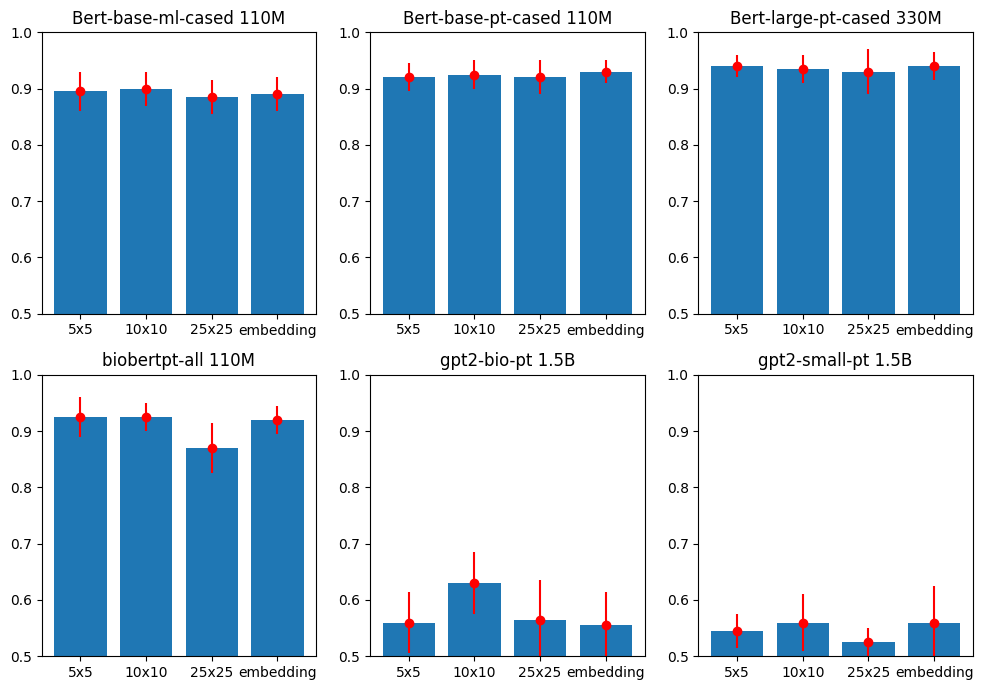

In [4]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10,7))
compass = -3

for index, row in df_summary.iloc[:-1,2:-1].groupby(by="model_size").mean().reset_index().iterrows():
    # print(row)
    ax = index if index < 3 else compass
    line = 0 if index < 3 else 1
    
    axes[line,ax].bar(['5x5', '10x10', '25x25', 'embedding'], [row['5x5_mean'], row['10x10_mean'], row['25x25_mean'], row['embedding_mean']])
    axes[line,ax].errorbar(['5x5', '10x10', '25x25', 'embedding'], [row['5x5_mean'], row['10x10_mean'], row['25x25_mean'], row['embedding_mean']],
                        yerr=[row['5x5_std'], row['10x10_std'], row['25x25_std'], row['embedding_std']], fmt="o", color="r")
    axes[line,ax].title.set_text(row['model_size'])
    axes[line,ax].set_ylim([.5,1])

    compass += 1

fig.tight_layout()
fig.savefig('images/f_pca_comparison' + exp + '.png', bbox_inches='tight')

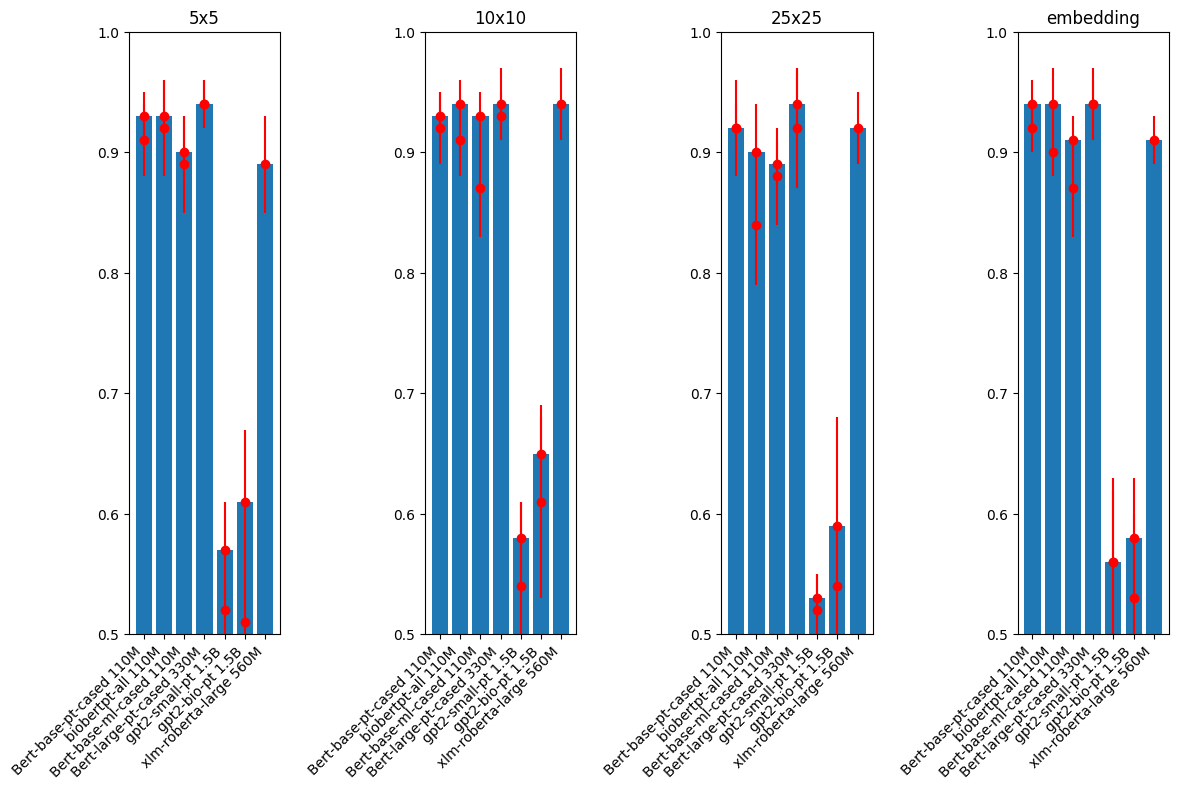

In [5]:
# sns.barplot(df_summary.swaplevel(0,1,1).sort_index(), x="name", y='mean',yerr='std')
# df_summary.iloc[:,2:]
# df_summary['model_size'] = ['dB', 'bB', 'cB', 'bL', 'rL', 'rXL']

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12,8))

axes[0].bar(df_summary['model_size'], df_summary['5x5_mean'])
axes[0].errorbar(df_summary['model_size'], df_summary['5x5_mean'], yerr=df_summary['5x5_std'], fmt="o", color="r")
axes[0].title.set_text("5x5")
axes[0].set_ylim([.5,1])

axes[1].bar(df_summary['model_size'], df_summary['10x10_mean'])
axes[1].errorbar(df_summary['model_size'], df_summary['10x10_mean'], yerr=df_summary['10x10_std'], fmt="o", color="r")
axes[1].title.set_text("10x10")
axes[1].set_ylim([.5,1])

axes[2].bar(df_summary['model_size'], df_summary['25x25_mean'])
axes[2].errorbar(df_summary['model_size'], df_summary['25x25_mean'], yerr=df_summary['25x25_std'], fmt="o", color="r")
axes[2].title.set_text("25x25")
axes[2].set_ylim([.5,1])

axes[3].bar(df_summary['model_size'], df_summary['embedding_mean'])
axes[3].errorbar(df_summary['model_size'], df_summary['embedding_mean'], yerr=df_summary['embedding_std'], fmt="o", color="r")
axes[3].title.set_text("embedding")
axes[3].set_ylim([.5,1])

# fig.ylim(0,1)
fig.tight_layout()
fig.autofmt_xdate(rotation=45)
fig.savefig('images/f_pca_comparison_dimensions' + exp + '.png')

# Carregando dados e configurando análise

In [6]:
# def label_answer(row, score, botton_quantile, top_quantile):
#     if (row[score] < botton_quantile):
#         return 'botton'
#     elif (row[score] > top_quantile):
#         return 'top'
#     else:
#         return 'mid'

# exp = "_iam"
# # exp = "_dpoc"

# df_traducao = pd.read_csv('data/experimento_consolidado' + exp + '.csv')

# score = 'global score'#organization_level,global_score
# quantile = .3
# map_dimension = 5
# # map_dimension = 10
# # map_dimension = 25

# model_ckpt = "distilbert-base-uncased"          # 67M
# # model_ckpt = "bert-base-uncased"                # 110M
# # model_ckpt = "emilyalsentzer/Bio_ClinicalBERT"
# # model_ckpt = "google-bert/bert-large-uncased"   # 336M
# # model_ckpt = "bvanaken/clinical-assertion-negation-bert"
# # model_ckpt = "gpt2"
# # model_ckpt = 'openai-community/gpt2'
# # model_ckpt = "openai-community/gpt2-large"
# # model_ckpt = "FacebookAI/xlm-roberta-large"     # 560M
# # model_ckpt = "facebook/xlm-roberta-xl"          # 3.48B
# # model_ckpt = "facebook/xlm-roberta-xxl"         # 10.7B
# # model_ckpt = "meta-llama/Meta-Llama-3-8B"
# # model_ckpt = "unsloth/Meta-Llama-3.1-8B"

# # print("Top quantil:", df_traducao[score].quantile(1 - quantile))
# # print("Botton quantil:", df_traducao[score].quantile(quantile))

# #df_traducao[score].hist()

# df_traducao['label'] = df_traducao.apply(
#     label_answer,
#     axis=1,
#     score=score,
#     botton_quantile=df_traducao[score].quantile(quantile),
#     top_quantile=df_traducao[score].quantile(1 - quantile),
# )

# columns_to_remove = list(df_traducao.columns)
# # print("All columns", columns_to_remove)
# columns_to_remove.remove('original')
# columns_to_remove.remove('label')

# df_data = df_traducao.rename(columns={'original': 'text'}).drop(columns=columns_to_remove).reset_index(drop=True)


# # df_data['label'].hist()
# # print("top:", df_data['label'].loc[df_data['label'] == "top"].count())
# # print("botton:", df_data['label'].loc[df_data['label'] == "botton"].count())
# # print("TOTAL:", df_data['label'].count())
# df_data.head()


# Passando os Dados para o Módulo

- converte o Dataframe para Dataset;
- carrega o modelo e os dados no módulo;
- processa as ativações;

In [7]:
# subset = Dataset.from_pandas(df_data)
# subset.cleanup_cache_files()

# label_feature = subset.features['label']
# class_names  = subset.unique("label")

# class_feature = features.ClassLabel(names=sorted(class_names))
# subset = subset.map(lambda str_value: {"label": class_feature.str2int(str_value)}, input_columns="label")

# subset = subset.cast(features.Features({
#     "label": class_feature,
#     "text": subset.features["text"]}))

In [8]:
# # device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'
# print('Using device:', device)

# llm_mri = LLM_MRI(model=model_ckpt, device=device, dataset=subset)

# llm_mri.process_activation_areas(map_dimension = map_dimension)

# *Evaluation* de todo Mapeamento

In [9]:
# df_model = pd.DataFrame(llm_mri.reduced_dataset[0]['label'])
# #df_model['norm_label']=(df_model['label']-df_model['label'].min())/(df_model['label'].max()-df_model['label'].min())

# print(df_model.columns.size)

# cell_numeration = {}

# for idx, data in enumerate(llm_mri.reduced_dataset):
#     df_mid = data[['label','cell_label']].pivot_table(index=data.index, columns="cell_label")
#     df_mid.columns = df_mid.columns.droplevel(0)

#     cell_numeration[idx] = [df_model.columns.size, df_model.columns.size + df_mid.columns.size]
    
#     df_model = pd.concat([
#         df_model,
#         df_mid
#     ], axis=1)


# df_model = df_model[(df_model['label'] == 0) | (df_model['label'] == 2)]
# # # df_model = df_model.replace(2.0, 'top')
# # # df_model = df_model.replace(0, 'botton')
# df_model = df_model.replace(2, 1)
# df_model.iloc[:,1:] = df_model.iloc[:,1:].notnull().astype('int')

# print(cell_numeration)

# df_model
# #pd.Series(df_model.iloc[:,2:].isnull().values.all(axis=0)).value_counts()
# # df_model

In [10]:
# # df_embedding = pd.DataFrame(llm_mri.reduced_dataset[0]['label'])

# df_embedding = llm_mri.hidden_states_dataset.to_pandas()['label']

# df_embedding = pd.concat([df_embedding, pd.DataFrame(llm_mri.hidden_states_dataset.to_pandas().iloc[:,-1].to_list())], axis=1)


# df_embedding = df_embedding[(df_embedding['label'] == 0) | (df_embedding['label'] == 2)]
# df_embedding['label'] = df_embedding['label'].replace(2.0, 1)
# # df_embedding['label'] = df_embedding['label'].replace(0, 0)
# # df_embedding = df_embedding.replace(2, 1)
# # df_embedding.iloc[:,1:] = df_embedding.iloc[:,1:].notnull().astype('int')

# # df_embedding

In [11]:
# map_c_scores = cross_val_score(LogisticRegression(), df_model.iloc[:,1:], df_model['label'], cv=4, scoring='f1_macro')
# emb_c_scores = cross_val_score(LogisticRegression(), df_embedding.iloc[:,1:], df_embedding['label'], cv=4, scoring='f1_macro')

# print("               mean      std")
# print("Mapping f1:    %0.2f      %0.2f" % (map_c_scores.mean(), map_c_scores.std()))
# print("Embbeding f1:  %0.2f      %0.2f" % (emb_c_scores.mean(), emb_c_scores.std()))

# pca = PCA(n_components=20)

# map_c_scores_pca = cross_val_score(LogisticRegression(), pca.fit_transform(df_model.iloc[:,1:]), df_model['label'], cv=4, scoring='f1_macro')
# emb_c_scores_pca = cross_val_score(LogisticRegression(), pca.fit_transform(df_embedding.iloc[:,1:]), df_embedding['label'], cv=4, scoring='f1_macro')

# print("PCA f1:        %0.2f      %0.2f" % (map_c_scores_pca.mean(), map_c_scores_pca.std()))
# print("PCA Emb f1:    %0.2f      %0.2f" % (emb_c_scores_pca.mean(), emb_c_scores_pca.std()))

In [12]:
# pca.fit_transform(df_model.iloc[:,1:])[0]